# Maximal Representative Subsampling

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy import stats

%run utils.py

path = Path(os.getcwd()).parent


## Attribute Comparison

Each row is labelled with its (survey) *source*.

- *Source*
- Geschlecht
- Geburtsjahr
- Hoechster Bildungsabschluss
- Erwerbstaetigkeit
- Soziale Unterstuetzung

### Preprocessing: Allensbach

In [2]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S05', 'V19']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 'Erwerbstaetigkeit',
                    'Soziale Unterstuetzung']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)

allensbach = allensbach.fillna(allensbach.median()) # quick fix, for the time being.
allensbach.rename(columns= dict(zip(allensbach_cols, allensbach_names)), inplace=True)

allensbach.head()

,Geschlecht,Geburtsjahr,Erwerbstaetigkeit,Soziale Unterstuetzung,Hoechster Bildungsabschluss
0,2,73,2,3,2
1,2,24,1,2,3
2,1,51,1,4,3
3,1,57,1,2,5
4,1,64,2,4,2


### Preprocessing: GBS

In [3]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

# Rename 'GBS-CODE' column
key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

# Merge GBS "Umfrage Wellen" and create dataframe
gbs = pd.merge(gbs1, gbs2, how='inner', on=key)
gbs = pd.merge(gbs, mapping1, how='left', on=key)
gbs = pd.merge(gbs, mapping2, how='left', on=key)

gbs_cols = ['am01', 'am02_01', 'am14', 'am17', 'os03']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 
                    'Erwerbstaetigkeit', 'Soziale Unterstuetzung',]

gbs = gbs[gbs_cols]
gbs.rename(columns= dict(zip(gbs_cols, allensbach_names)), inplace=True)


del mapping1, mapping2, gbs1, gbs2

# TODO: Combine matching rows instead of selecting every 2nd.
gbs = gbs.iloc[::2, :]


di1 = {'männlich': 1, "Männlich": 1, 'weiblich': 2, "Weiblich": 2, '[NA] Keine Angabe':np.nan}
gbs.replace({"Geschlecht": di1}, inplace=True)

gbs['Geburtsjahr'] = [2017-(int)(gj[:4]) if gj is not np.nan else np.nan for gj in gbs.Geburtsjahr]

di2 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}

gbs.replace({'Hoechster Bildungsabschluss': di2}, inplace=True)

di3 = {9:2,
       999:2,
      -3:2,
      -1:2,
      3:2}

# Note: this is also allensbach replacement using same dict
allensbach = allensbach.replace({'Erwerbstaetigkeit': di3})
allensbach['Erwerbstaetigkeit'] = [int(i) for i in allensbach.Erwerbstaetigkeit]

di4 = {'sehr viel Anteilnahme und Interesse':5, 
       'viel Anteilnahme und Interesse': 4, 
       'weder viel noch wenig': 3, 
       'wenig Anteilnahme und Interesse': 2, 
       'keine Anteilnahme und Interesse': 1,
       'keine Angabe':3}
gbs.replace({'Soziale Unterstuetzung': di4}, inplace=True)

gbs.head(5)

,Geschlecht,Geburtsjahr,Hoechster Bildungsabschluss,Erwerbstaetigkeit,Soziale Unterstuetzung
0,1.0,38.0,4.0,1.0,4.0
2,2.0,72.0,5.0,1.0,3.0
4,1.0,68.0,5.0,1.0,4.0
6,2.0,25.0,5.0,1.0,4.0
8,2.0,33.0,2.0,1.0,4.0


### Preprocessing: GESIS

We might need this later.

In [4]:
gesis1 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_a11-a12_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis2 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ca-cf_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis3 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ba-bf_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis4 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_aa-ac_v22-0-0 (1).dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")

gesis5 = pd.merge(gesis1, gesis2, how='inner', on='z000001a')
gesis6 = pd.merge(gesis3, gesis4, how='inner', on='z000001a')
gesis  = pd.merge(gesis5, gesis6, how='inner', on='z000001a')

del gesis1,gesis2,gesis3,gesis4,gesis5,gesis6

gesis = gesis[['a11d054a', 'a11d056b', 'a11d082b', 'a11d089c', 
              'a11d092a', 'acae051a', 'acae058a', 'acae062a', 
              'acae079a', 'acae089a', 'acae099a', 'acae085a', 
              'acae095a', 'acae105a', 'bdao099a']]
gesis.head(5)

,a11d054a,a11d056b,a11d082b,a11d089c,a11d092a,acae051a,acae058a,acae062a,acae079a,acae089a,acae099a,acae085a,acae095a,acae105a,bdao099a
0,Männlich,1946,"Fachhochschulreife, Fachoberschule",Nicht erwerbstätig,Missing by filter,Stimme zu,Weder noch,Missing by design,8,Missing by design,Missing by design,6,Missing by design,Missing by design,Mittelschicht
1,Weiblich,1974,Hauptschulabschluss,Vollzeiterwerbstätig,Angestellte(r),Weder noch,Stimme zu,Missing by design,Missing by design,5,Missing by design,Missing by design,3,Missing by design,Weiß ich nicht
2,Weiblich,1994,Schüler/-in,Nicht erwerbstätig,Missing by filter,Stimme zu,Lehne stark ab,Missing by design,9,Missing by design,Missing by design,6,Missing by design,Missing by design,Unit nonresponse
3,Männlich,1950,"Abitur, allgemeine oder fachgebundene Hochschu...",Vollzeiterwerbstätig,Angestellte(r),Stimme zu,Stimme stark zu,Missing by design,Missing by design,Missing by design,Item nonresponse,Missing by design,Missing by design,6,Keiner dieser Schichten
4,Männlich,1990,Realschulabschluss,Vollzeiterwerbstätig,Angestellte(r),Stimme zu,Missing by design,Lehne ab,8,Missing by design,Missing by design,5,Missing by design,Missing by design,Not reached


- "['a12d021a' 'a12d024a' 'dezg083a'] not in index"

## Experiment

In [19]:
allensbach['label'] = 'rep'
gbs['label'] = 'nonrep'

rep = allensbach.copy(deep=True)
non_rep = gbs.copy(deep=True)

data = pd.concat([rep, non_rep], sort=True).copy(deep=True)

data = data.fillna(data.median()) # quick fix, for the time being.
data.reset_index(drop=True, inplace=True)

data['probs'] = len(data.label)*[0]

data.head()

,Erwerbstaetigkeit,Geburtsjahr,Geschlecht,Hoechster Bildungsabschluss,Soziale Unterstuetzung,label,probs
0,2.0,73,2.0,2,3,rep,0
1,1.0,24,2.0,3,2,rep,0
2,1.0,51,1.0,3,4,rep,0
3,1.0,57,1.0,5,2,rep,0
4,2.0,64,1.0,2,4,rep,0


In [26]:
temperature = 1 
max_drop = 1

ks = []
auc = []
subset = []


while (len(data[data.label == 'nonrep']) > max_drop):

    rf = RandomForestClassifier(n_estimators=250, 
                                bootstrap=True,
                                max_depth=10,
                                oob_score=True,
                                n_jobs=-1)
    
    probs = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3,
                              method='predict_proba')
    
    preds = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3)
    
    if preds[0] == 'nonrep' and round(probs[0][0], 0) == 1:
        data['probs'] = [p[1] for p in probs]
    else:
        data['probs'] = [p[0] for p in probs]
    
    drop_id = []
    for _ in range(max_drop):
        softmax = sample(data[data.label == 'nonrep']['probs'], temperature)
        drop = data[data.label == 'nonrep'].iloc[[np.argmax(softmax)]].index[0]
        drop_id.append(drop)
        
    data.drop(data.index[drop_id], inplace=True)
    data.reset_index(drop=True, inplace=True)

    if drop_id in test.index:
        test.drop(test.index[drop_id], inplace=True)
        test.reset_index(drop=True, inplace=True)
    
    # EVALUATION
    subset.append(len(data[data.label == 'nonrep']))
    auc.append(roc([1 if k == 'nonrep' else 0 for k in data.label], data.probs, 1, 'name'))    
    ks.append(stats.ks_2samp(data[data.label == 'nonrep']['probs'], 
                             data[data.label == 'rep']['probs']))

    print('length of current GBS subset:', len(data[data.label == 'nonrep'].label))

In [21]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

subset = [i for i in range(1, 504)]

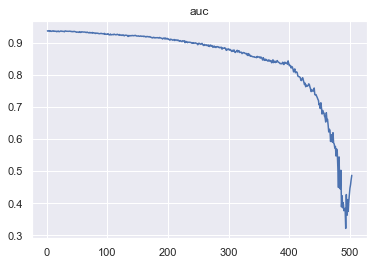

In [22]:
ax = sns.lineplot(x=subset, y=auc)
plt.title('auc')
plt.show()

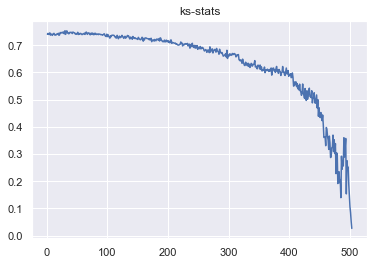

In [23]:
ax = sns.lineplot(x=subset, y=[a[0] for a in ks])
plt.title('ks-stats')
plt.show()

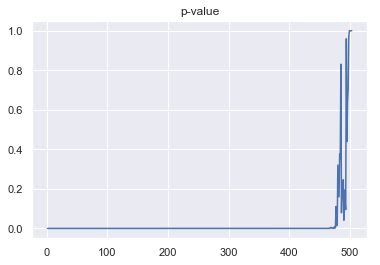

In [24]:
ax = sns.lineplot(x=subset, y=[a[1] for a in ks])
plt.title('p-value')
plt.show()